\begin{equation*}
\Large\hat y = \sigma(\sum_{\mu = 0}\sum_{i = 0}(W_{\mu, i} \times X_{\mu, i}))
\end{equation*}

<br>

\begin{equation*}
\Large\delta_{0} = (y - \hat y) \times f'(h_{\mu})
\end{equation*}

<br>

\begin{equation*}
\Large\delta_{\mu} = \sum_{i=0}[W_{\mu, i} \times \delta_{0}] \times f'(h_{\mu})
\end{equation*}

<br>

\begin{equation*}
\Large\Delta W_j = \Delta W_j + \delta_{j} \times X_{j}
\end{equation*}

<br>

\begin{equation*}
\Large W_{j} = W_{j} + \eta \times \Delta W_j
\end{equation*}

# Import the dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<br>

# Activation functions

In [2]:
class Activation():
    def fn(self, x):
        raise ValueError("Method Layer.fn was not implemented!")
    
    def fn_prime(self, x):
        raise ValueError("Method Layer.fn_prime was not implemented!")

In [3]:
class EmptyActivation():
    def fn(self, x):
        return x
    
    def fn_prime(self, x):
        return x

In [4]:
class Sigmoid():
    def fn(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fn_prime(self, x):
        return self.fn(x) / (1 + self.fn(x))

<br>

# Activation functions

In [5]:
class MSE():
    @staticmethod
    def fn(y, y_hat):
        return np.mean((y - y_hat) ** 2)

<br/>

# Create the basic layer

In [6]:
class Layer:
    
    def __init__(self):
        self.__input = None
        self.__output = None
    
    def forward(inputs):
        raise ValueError('Method Layer.forward was not implemented!')
    
    def backward(error):
        raise ValueError('Method Layer.backward was not implemented!')
    
    def commit(error):
        raise ValueError('Method Layer.commit was not implemented!')

<br/>

# Create the dense layer

In [45]:
class Dense(Layer):
    def __init__(self, input_size, size, activation='relu', learnrate=0.1):
        self.__input = None
        self.__output = None
        self.__neurons_size = size
        self.__weights = np.random.normal(scale=1 / input_size ** .5, size=(input_size+1, size))
        self.__learnrate = learnrate
        self.__size = size
        
        self.reset_train()
        
        if activation.lower() == 'sigmoid':
            self.__activation = Sigmoid()
        else:
            self.__activation = EmptyActivation()
    
    def reset_train(self):
        self.__del_w = np.zeros(self.__weights.shape)
        self.__train_records = 0
    
    def forward(self, inputs):
        inputs = np.array(inputs)
        
        if len(inputs.shape) == 1:
            inputs = inputs.reshape(1, inputs.shape[0])

        inputs = np.concatenate((inputs, [[1]],), axis=1)
        
        self.__input = inputs
        summ = np.dot(self.__input, self.__weights)
        
        self.__output = self.__activation.fn(summ)
        return self.__output
    
    def backward(self, error):
        sigma = np.sum(np.sum(error) * self.__activation.fn_prime(np.dot(self.__input, self.__weights)))
        del_w = sigma * self.__input.reshape((self.__input.shape[1], self.__input.shape[0],))
        
        self.__del_w += del_w
        self.__train_records += 1
        
        return np.dot(sigma, self.__weights)
    
    def commit(self):
        self.__weights += self.__learnrate * self.__del_w / self.__train_records
        
        self.reset_train()

### Testing

In [46]:
x = np.arange(0, 10)

n = Dense(input_size=10, size=1, activation='sigmoid')

error = 1 - n.forward(x)

print(n.forward(x))

n.backward(np.array([error]))

[[0.00164535]]


array([[ 2.11256273e-04],
       [ 6.14312931e-04],
       [ 3.54517156e-04],
       [ 6.88417133e-04],
       [ 2.86069065e-04],
       [ 7.60706143e-04],
       [-6.50162930e-04],
       [-8.31524891e-04],
       [-9.58536344e-05],
       [-8.18803615e-04],
       [-9.87731076e-04]])

<br/>

# Defining the Gradient Descent Network

In [47]:
class Network:
    def __init__(self):
        self.__layers = []
    
    def add(self, layer):
        self.__layers.append(layer)
    
    def __forward(self, inputs):
        input_next = inputs
        
        for layer in self.__layers:
            input_next = layer.forward(input_next)
        
        return input_next
    
    def __backward(self, errors):
        errors_next = errors
        
        for layer in self.__layers[::-1]:
            error = layer.backward(errors_next)

    def __commit(self):
        for layer in self.__layers:
            error = layer.commit()
            
    def fit(self, X_train, y_train, X_test, y_test, epochs):
        history = {'accuracy': [], 'loss': []}
        
        for e in range(epochs):
            for features, target in zip(X_train, y_train):
                
                target = np.array(target)
                features = np.array(features)
                
                # Propagate the features through the network
                y_h = self.__forward(features)
                
                # Calculate the error
                error = target - y_h
                
                # Backpropagate the error and commit changes into weights 
                self.__backward(error)
                self.__commit()

            # Predict the test results
            h = self.predict(X_test)

            # Measure the Accuracy
            accuracy = accuracy_score(y_test, np.around(h, decimals=0) )

            # Measure the loss
            loss = MSE.fn(h, y_test)

            history['accuracy'].append(accuracy)
            history['loss'].append(loss)
        
        return history
    
    def predict(self, X):
        return np.array([self.__forward(x)[0] for x in X])

<br/>

# Testing

### Prepare the dataset

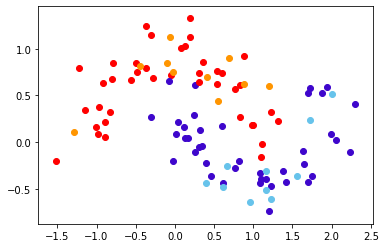

In [48]:
# Generate 2D dataset
# X, y = make_blobs(n_samples=100, centers=2, n_features=2, center_box=(-20, 20))
X, y = make_moons(n_samples=100, noise=0.2)

# Split in train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

labels = {0:'red_train', 1:'blue_train', 2:'red_test', 3:'blue_test'}
colors = {0:'red', 1:'#3e06cc', 2:'#ff9500', 3:'#67c3eb'}

# Plot train dataset 
for x, key in zip(X_train, y_train):
    plt.scatter(x[0], x[1], color=colors[key])

# Plot test dataset
for x, key in zip(X_test, y_test):
    plt.scatter(x[0], x[1], label=labels[key+2], color=colors[key+2])

plt.show()

### Train the network

In [53]:
# Create a new Neural Network
net = Network()

# Add first layer
net.add(Dense(input_size=2, size=2, activation='sigmoid'))

# Add second layer layer
net.add(Dense(input_size=2, size=1, activation='sigmoid'))

# Train the model and valid using the test dataset
history = net.fit(X_train, y_train, X_test, y_test, epochs=100)

### Ploting the results

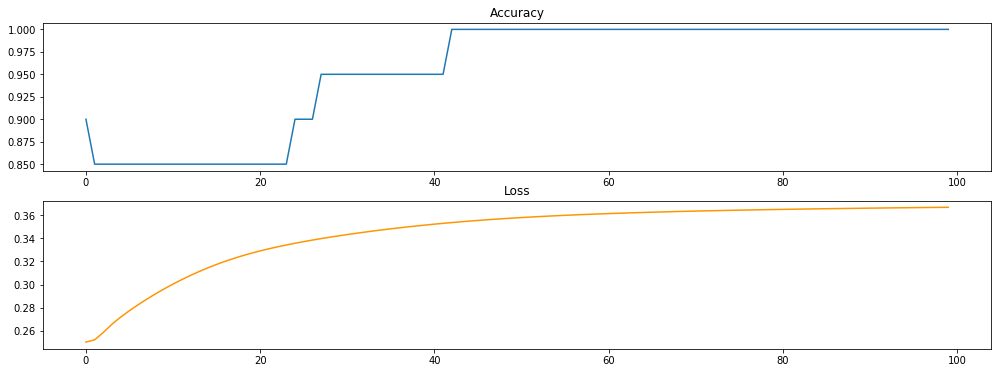

In [54]:
x_plot = np.arange(len(history['accuracy']))

# Create a new subplot
fig, axis = plt.subplots(2, 1, figsize=(17,6))

# Plot the accuracy in first graph
axis[0].plot(x_plot, history['accuracy'], label="Accuracy")
axis[0].title.set_text("Accuracy")

# Plot the loss in second graph
axis[1].plot(x_plot, history['loss'], label="Loss", color="#ff9500")
axis[1].title.set_text("Loss")

plt.show()

### Accuracy

In [56]:
from IPython.core.display import display, HTML
display(HTML('<h2>Accuracy: {:.2f} %</h2>'.format(accuracy_score(y_test, np.around(net.predict(X_test), decimals=0) ) * 100)))